## PART 1: Descriptive Statistics and Exploratory Data Analysis

### Initializations

First we import some useful modules for statistics, then do some necessary settings:

In [427]:
import numpy as np
import statsmodels as sts
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as scst
import statsmodels.api as sm
import sklearn.linear_model as sklm
import sklearn as skl

In [3]:
sns.set_context('talk')

In [4]:
%matplotlib inline

### Import Data

First we must import the data from file. We use `raw` as identifier of the raw data.

In [5]:
raw = pd.read_csv("G:\Study\Statistics\Thesis\data.csv", index_col='Index')

### Basic Descriptive Statistics

The data are organized in a 2D table, let's look at the head of it.

Here we have already **encode "Gender" with binary number**(1 for male, 0 for female).

In [6]:
raw.columns = ['Gender', 'Height', 'Weight', 'ArmSpan', 'Leglength', 'FeetLength']
print raw.columns

Index([u'Gender', u'Height', u'Weight', u'ArmSpan', u'Leglength',
       u'FeetLength'],
      dtype='object')


In [7]:
raw.head(5)

,Gender,Height,Weight,ArmSpan,Leglength,FeetLength
Index,,,,,,
1,1,185.0,65.0,188.0,102.0,25.1
2,1,173.0,62.0,182.0,93.0,23.5
3,1,175.0,80.3,183.0,107.0,26.5
4,1,182.0,74.3,189.0,114.0,26.0
5,1,173.0,55.7,185.0,107.0,26.0


Look at some simple statistics of each **quantitative** variable: 

In [8]:
raw.loc[:, 'Height': 'FeetLength'].describe()

,Height,Weight,ArmSpan,Leglength,FeetLength
count,90.000000,90.000000,90.000000,90.000000,90.000000
mean,172.383333,63.062222,169.740000,95.725556,24.600000
std,7.922394,11.893645,10.506047,7.934076,1.763997
min,155.000000,42.000000,136.600000,77.000000,20.000000
25%,166.500000,55.000000,164.000000,91.000000,23.425000
50%,172.000000,60.250000,169.500000,97.000000,24.500000
75%,178.750000,69.750000,177.000000,101.000000,26.000000
max,187.000000,99.000000,196.000000,119.000000,29.000000


### Distributions of Variables

Then we plot **histgrams** of each varible to see their **sample distribution**.

First let's compare the number of different genders

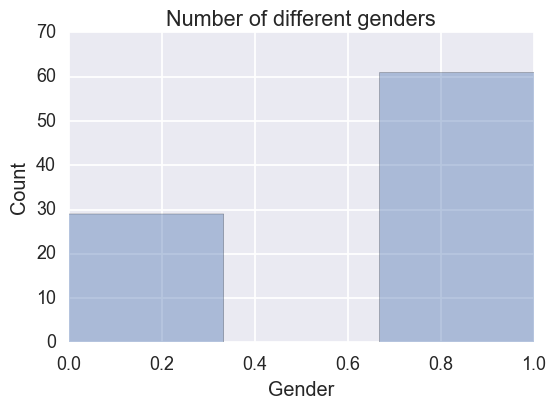

In [9]:
plt.figure()
sns.distplot(raw.loc[:, 'Gender'], kde=False)
plt.title('Number of different genders')
plt.ylabel('Count')

Then we look at distributions of quantitative data. We plot their histgrams, probability density estimations and corresponding data points at the same time:

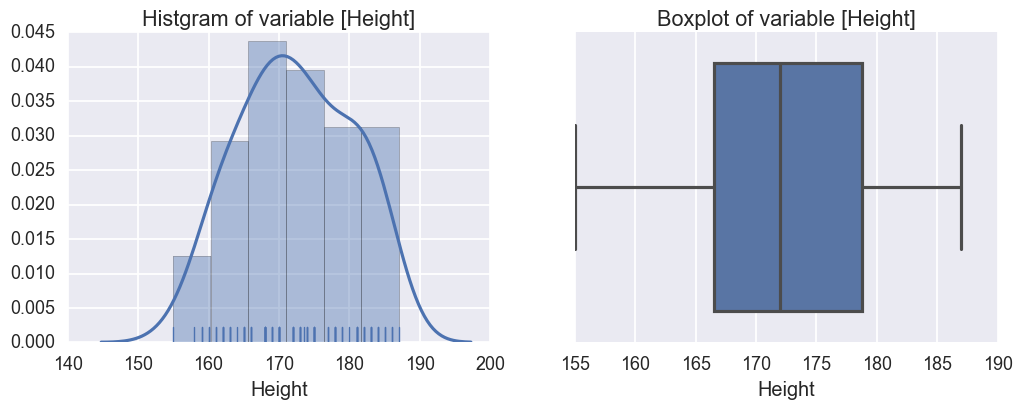

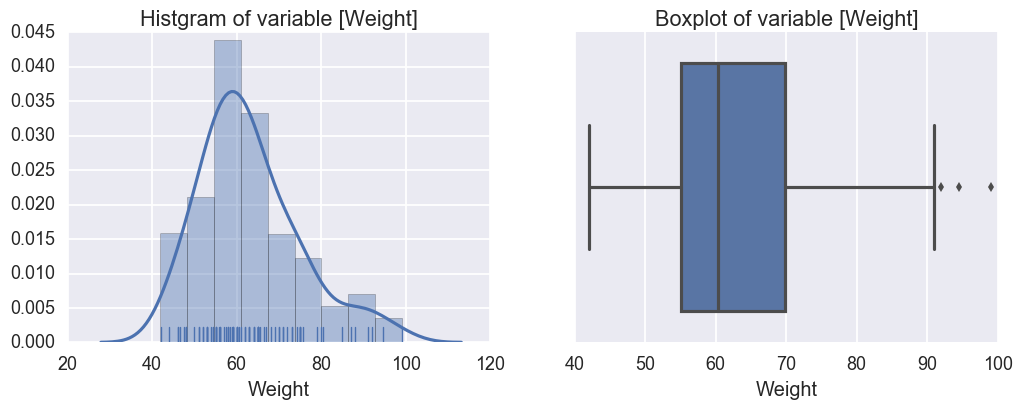

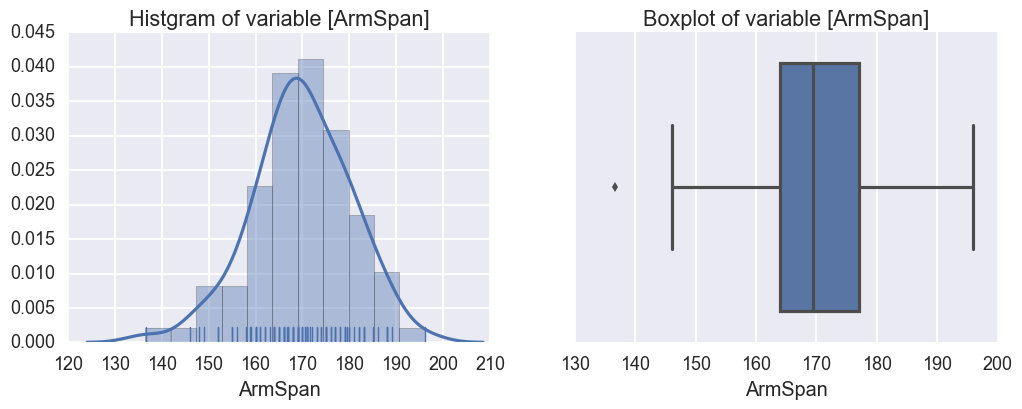

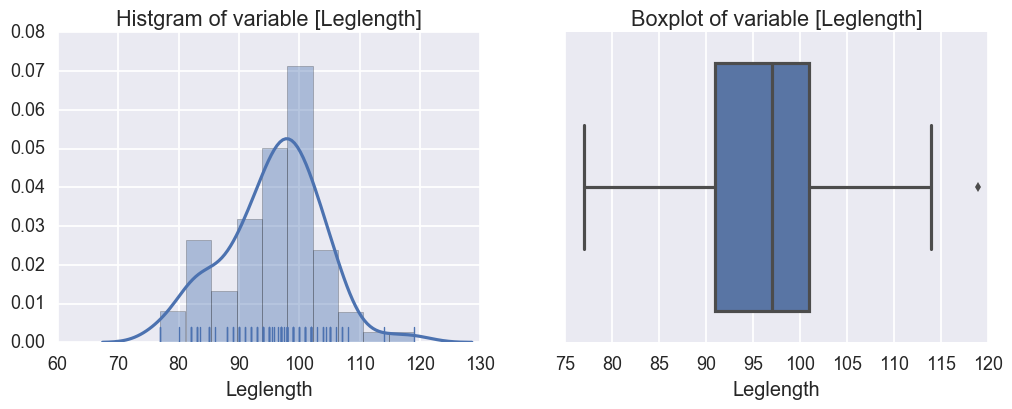

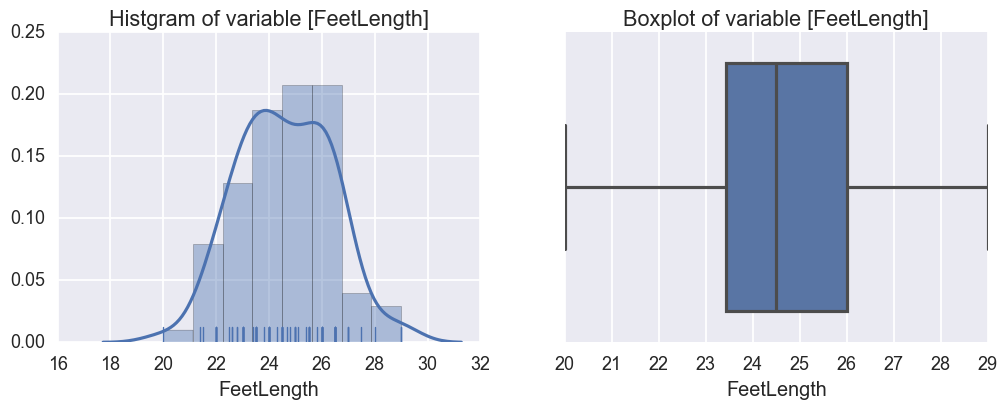

In [10]:
for col, ser in raw.iteritems():
    if col == 'Gender':
        continue
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    sns.distplot(ser, rug=True, ax=ax1)
    sns.boxplot(ser, ax=ax2)
    ax1.set_title('Histgram of variable [{0}]'.format(col))
    ax2.set_title('Boxplot of variable [{0}]'.format(col))

According to histgrams, we don't see any ***outliers***, which means our data is relatively "clean".

### Correlations Between Variables

First we look at **pairwise scatter plot** between varibales:

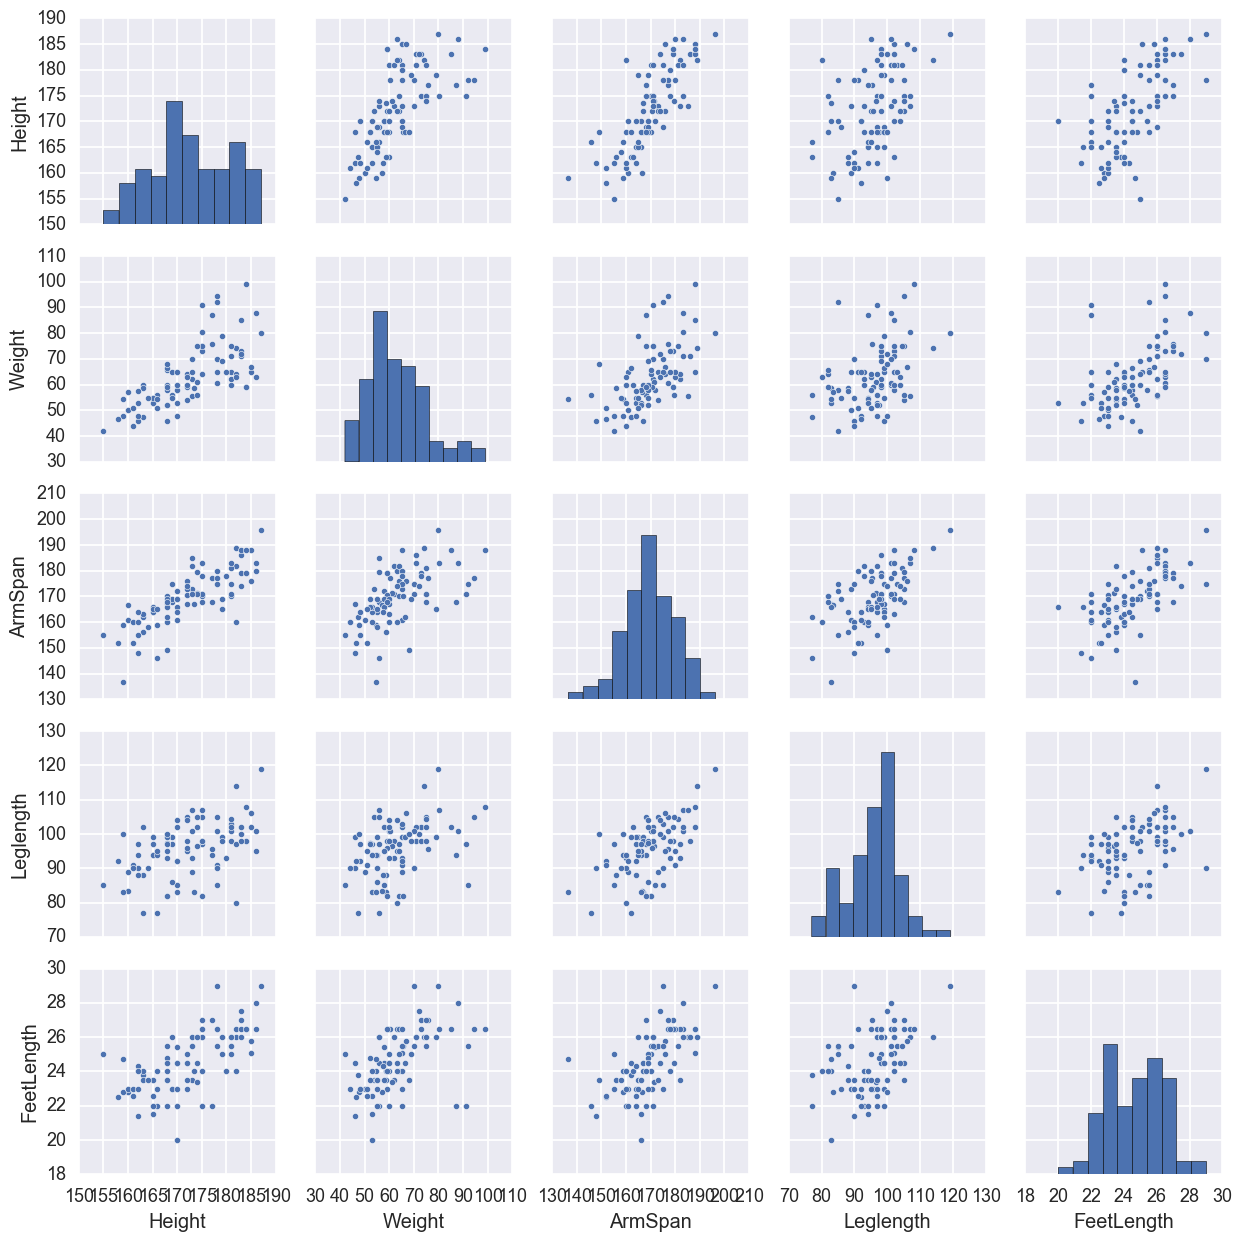

In [11]:
sns.pairplot(raw.loc[:, 'Height':])

All these 4 quantitative varibles (`Height`, `Weight`, `ArmSpan`, `LegLength`) are positively correlated, which is consistent with our intuition.

We would like to see how close are these pairs correlated. Therefore we draw a **heat map of coefficients of correlation**:

In [12]:
raw_corr = raw.loc[:, 'Height': ].corr()
raw_corr

,Height,Weight,ArmSpan,Leglength,FeetLength
Height,1.000000,0.683862,0.794692,0.475839,0.669490
Weight,0.683862,1.000000,0.573615,0.400981,0.530893
ArmSpan,0.794692,0.573615,1.000000,0.570437,0.640298
Leglength,0.475839,0.400981,0.570437,1.000000,0.448429
FeetLength,0.669490,0.530893,0.640298,0.448429,1.000000


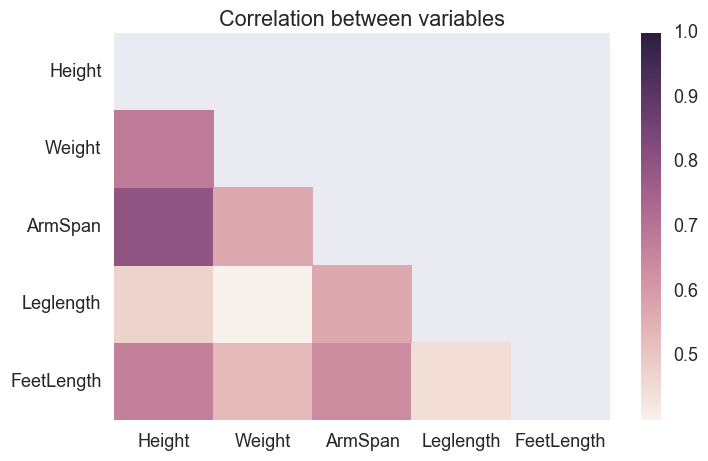

In [13]:
mask = np.zeros_like(raw_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.heatmap(raw_corr, mask=mask, ax=ax)
plt.title('Correlation between variables')

It is indicated by the heatmap above that `ArmSpan` and `Weight` are most closely correlated with `Height`, so we should take a deeper look at their relationship:

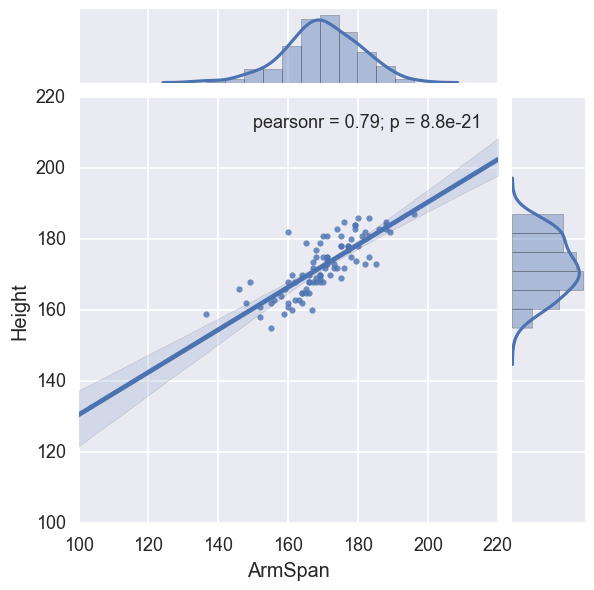

In [15]:
sns.jointplot(data=raw, x='ArmSpan', y='Height', kind='reg')

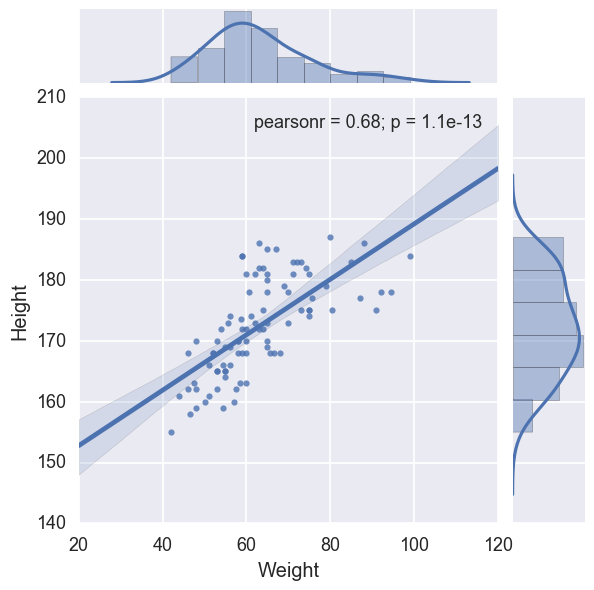

In [17]:
sns.jointplot(data=raw, x='Weight', y='Height', kind='reg')

We will stop exploring the relationships between variables for now. In PART 3, we will do more analysis on regression.

## PART 2: Statistical Inference

In this part we will do **non-parametric and parametric hypothesis test** to try to get some understanding of the population. After we successfully know the type of distribution of the population, we will do **parameter estimation**. 

Finally we would like to test whether significant difference exsists between populations of male and female.

### Nonparametric Test: Normality

#### Graphical Method

We draw **QQ-plot** to create a graphical normality test:

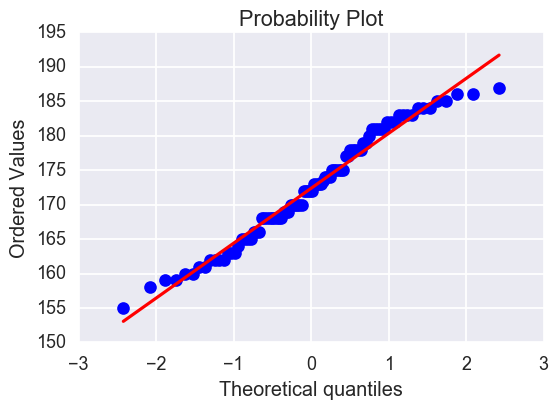

In [33]:
_, _ = scst.probplot(raw['Height'], dist='norm', plot=plt)

It is shown that the distribution of `Height` diverges from a normal distribution. Thus we should do some further check. 

#### Skewness & Kurtosis Test 

Let's do something **serious**. 

In our textbook we learned "峰度、偏度检验", in which we test normality according to **either the skewness or kurtosis** of the sample. I also find on the Internet that based on *D’Agostino and Pearson (1973)*, there is a test that **combines skew and kurtosis** to produce an omnibus test of normality. The new statistic is:
$$
K^2 = z_1^2 + z_2^2,
$$
where $z_1$ and $z_2$ are the statistics from skewness and kurtosis test.

Here we will conduct these 3 tests respectively:  
1. skewness test
2. kurtosis test
3. omnibus k-square test

For convenience of future use, we define a function which can do these tests and tell the results.

In [65]:
def norm_test_sk(data, axis=0, nan_policy='propagate'):
    st_skew, pv_skew = scst.skewtest(data, axis=axis, nan_policy=nan_policy)
    st_kurt, pv_kurt = scst.kurtosistest(data, axis=axis, nan_policy=nan_policy)
    st_omni, pv_omni = scst.normaltest(data, axis=axis, nan_policy=nan_policy)
    
    round_num = 5
    pv_skew, pv_kurt, pv_omni = round(pv_skew, round_num), round(pv_kurt, round_num), round(pv_omni, round_num)
    
    arr = np.array([[st_skew, pv_skew], [st_kurt, pv_kurt], [st_omni, pv_omni]])
    df = pd.DataFrame(index=['Skewtest', 'Kurtosistest', 'Omnitest'], columns=['Statistic', 'P value'], data=arr)
    df.index.name = 'Test Name'
    return df

In [66]:
print norm_test_sk(raw['Height'])

              Statistic  P value
Test Name                       
Skewtest      -0.083903  0.93313
Kurtosistest  -3.114583  0.00184
Omnitest       9.707668  0.00780


From pvalues of three tests above, we can see clearly that compared to normal distribution, **the distribution of `Height` is rather symmetric** (the *tail* on the left side is slightly *fatter*) while **the distribution of `Height` is much more *flatter* **than that of normal one. This explains why we can **reject the null hypothesis with more than $99\%$ confidence** (p value = 0.00780).

As a confirmation, we plot the distribution of `Height`, **together with a normal distribution** with the same mean and variance:

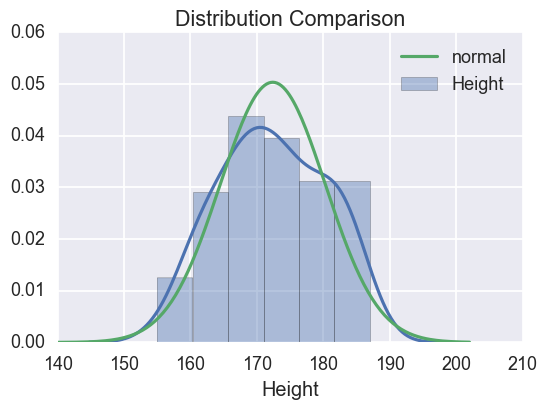

In [92]:
tmp = scst.norm(raw['Height'].mean(), raw['Height'].std())

xran = np.linspace(raw['Height'].min()-15, raw['Height'].max()+15, 200)
sns.distplot(raw['Height'], label='Height')

plt.plot(xran, tmp.pdf(xran), label='normal')
plt.legend(loc='best')
plt.title('Distribution Comparison')

#### Pearson Chi-Squared Goodness of Fit Test

We will use `scipy.stats.chisquare` to conduct this test. The function can only accept discret data, so we have to **divide data points and calculate expected data ourselves**. The following `norm_test_chisq` will do this: 

In [219]:
def norm_test_chisq(ser):
    """Group the sample data, return the frequency in each 
    group of the sample and the corresponding normal distribution.
    
    Parameters
    -----------
    ser : pd.Series. The sample data.
    
    Returns
    --------
    bins : np.array. Bins of each group.
    freq_obs : np.array. Sample frequency in each group.
    freq_exp : np.array. Expected frequency (the normal distribution) in each group.
    
    """
    lower, upper = ser.min(), ser.max()
    mean, std = ser.mean(), ser.std()
    n = len(ser)
    
    num_of_bins = round(1.87 * (n - 1)**0.4)
    bins=np.linspace(lower, upper, num_of_bins)
    
    norm_sample = mean + std * np.random.randn(6666)
    
    count_obs, _ = np.histogram(ser, bins=bins)
    count_exp, _ = np.histogram(norm_sample, bins=bins)
    freq_exp = np.diff(np.array(map(lambda x: scst.norm.cdf(x, mean, std), bins)))
    
    return bins, count_obs, freq_exp * n

Now we can feed the data into test function (here we also plot the `observed` and `expected` counts as a confirmation):

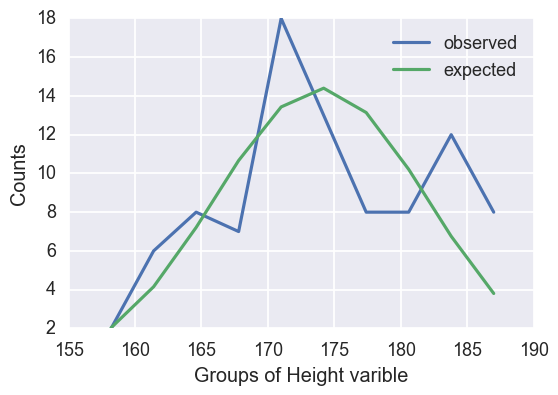

The result of Chi-Squared test:
statistic: 15.0549816151 
  P value: 0.0894367551011


In [220]:
bins, observed, expected = norm_test_chisq(raw['Height'])
plt.plot(bins[1:], observed, label='observed')
plt.plot(bins[1:], expected, label='expected')
plt.xlabel('Groups of Height varible')
plt.ylabel('Counts')
plt.legend(loc='best')
plt.show()
st, pv = scst.chisquare(observed, expected)
print ('The result of Chi-Squared test:\n' 
       + 'statistic: {0} \n'.format(st) +' '*2 + 'P value: {0}'.format(pv))

Again, we can **reject** the null, with the significance level $\alpha \approx 9\%$.

#### Shapiro Test

Recently A study(*Razali, Nornadiah; Wah, Yap Bee, 2011*) concludes that **Shapiro–Wilk has the best power for a given significance**, followed closely by Anderson–Darling when comparing the Shapiro–Wilk, Kolmogorov–Smirnov, Lilliefors, and Anderson–Darling tests.

So we decide to check it out:

In [221]:
scst.shapiro(raw['Height'])

(0.9728114604949951, 0.055891621857881546)

Another rejection! With significance level $\alpha \approx 5 \%$!

#### Normality test for other variables

In [363]:
def norm_test(dataframe):
    index=['Skewness', 'Kurtosis', 'Omnibus', 'Chi-Squared', 'Shapiro']
    index = list(map(lambda x: x+'Test', index))
    columns=['Statistic', 'P value']
    
    df_list = []

    for col, ser in dataframe.iteritems():
        if col == 'Gender':
            continue
        df = pd.DataFrame(index=index, columns=columns)
        
        st_pv_0 = norm_test_sk(ser).values
        _, observed, expected = norm_test_chisq(ser)
        st1, pv1 = scst.chisquare(observed, expected)
        st2, pv2 = scst.shapiro(ser)
        
        df.ix[0: 3, :2] = st_pv_0
        df.ix[3, :2] = st1, pv1
        df.ix[4, :2] = st2, pv2
        
        df_list.append(df.T)

    normality_test_table = pd.concat(df_list, keys=dataframe.columns[1:].values)
    normality_test_table.index.names = ['Variable', ''] 
    return normality_test_table

In [364]:
norm_test(raw)

SkewnessTest KurtosisTest OmnibusTest Chi-SquaredTest  \
Variable                                                                     
Height     Statistic   -0.0839026     -3.11458     9.70767          15.055   
           P value        0.93313      0.00184      0.0078       0.0894368   
Weight     Statistic      3.18137      1.31255     11.8439          16.944   
           P value        0.00147      0.18933     0.00268       0.0496007   
ArmSpan    Statistic     -1.13123      1.10381     2.49807          3.5557   
           P value        0.25796      0.26967     0.28678        0.938153   
Leglength  Statistic    -0.691328     0.720531    0.997099         17.4884   
           P value        0.48936       0.4712     0.60741       0.0415945   
FeetLength Statistic     0.281289    -0.398828    0.238187         12.4828   
           P value        0.77849      0.69002     0.88772        0.187439   

                     ShapiroTest  
Variable                          
Height     Statistic    0.972811  
           P value     0.0558916  
Weight     Statistic    0.947405  
           P value    0.00116142  
ArmSpan    Statistic    0.990688  
           P value      0.780253  
Leglength  Statistic    0.978126  
           P value      0.133378  
FeetLength Statistic    0.982427  
           P value      0.265105

According to the table, we can say, at $95\%$ confidence level, that **`Height` and `Weight` are not normally distributed**, while the other three varibales are normal.

### Analysis of The Divergence From Normality

It is a **common sense** that (at the same age) the distribution of human height is normal. This is also written in many textbooks. 

Why does our analysis generate a conflict result? There are several **possible explainations**:
1. It is indeed not normal. We should choose other models to fit.
2. Our data is not "clean" (without necessary preprocessing)
3. Our dataset is too small to help us reveal the pattern

From the work of *Schilling, M., Watkins, A., & Watkins, W. (2002)*, we know that the **height of male and female have different means**. This inspires us to check **second possible expaination**, i.e. to separate data of male and female.

We encode the variable `Gender` with different colors:

### Test whether the distributions of different genders are different

#### Visualization of different genders

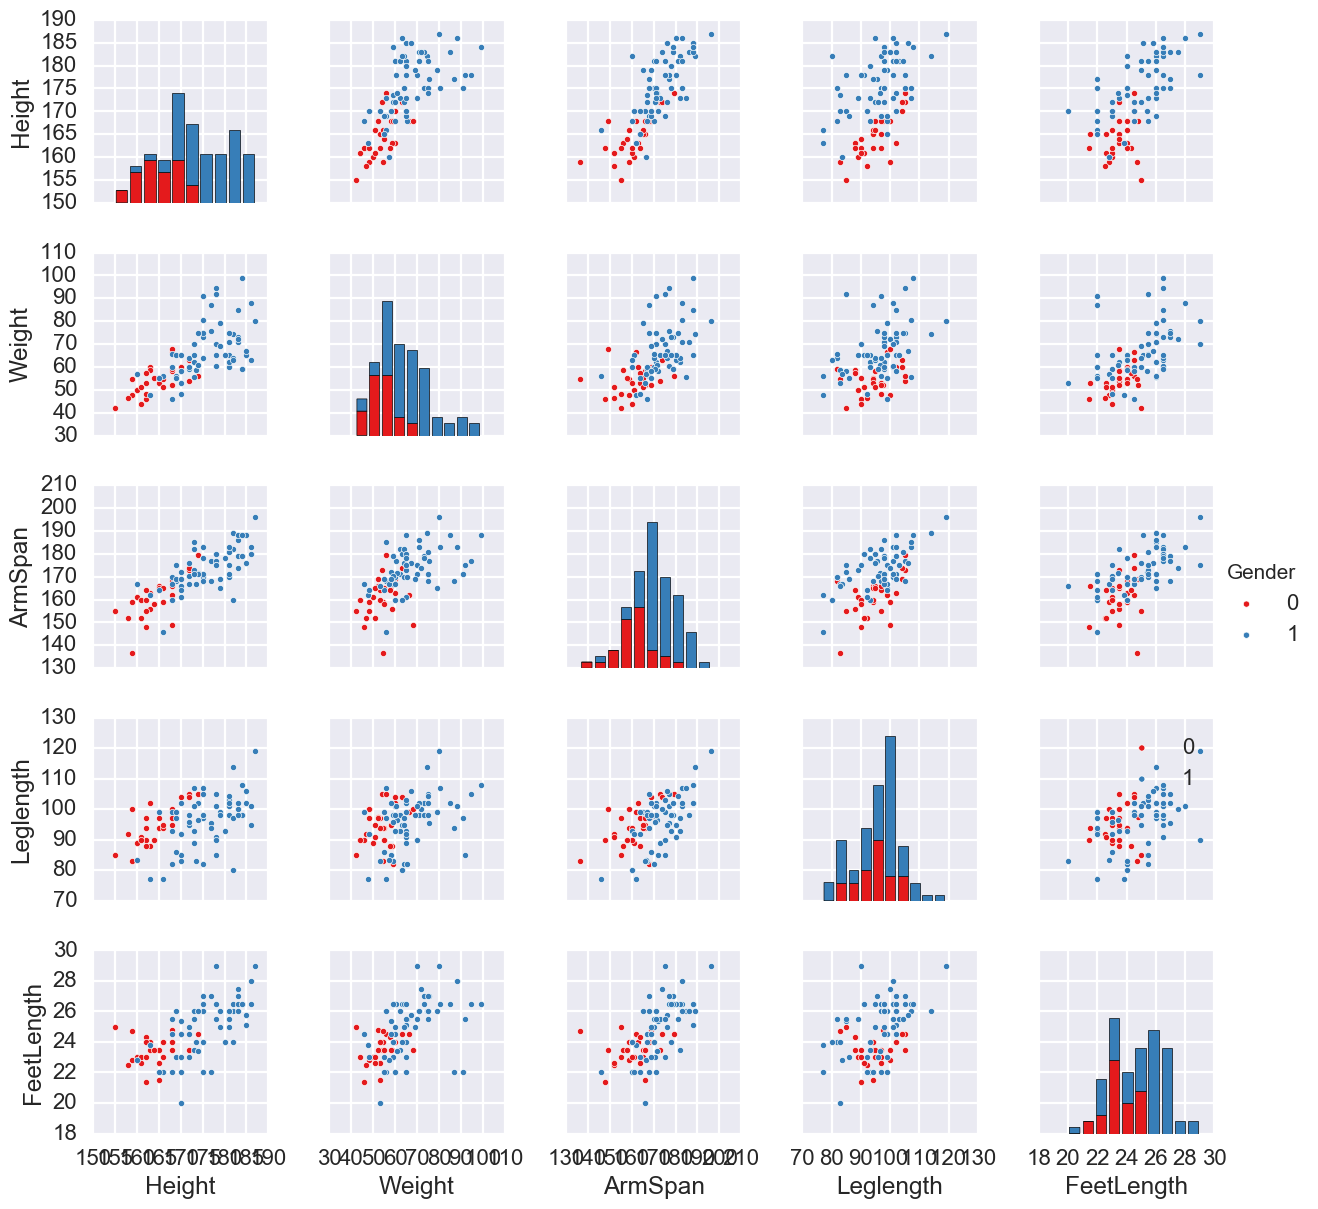

In [561]:
sns.pairplot(raw, hue='Gender', x_vars=raw.columns[1:], y_vars=raw.columns[1:], palette='Set1')
plt.legend()

Clearly, we see the data points of male and female **belong to different groups**.

#### Hypothesis tests

Further, the research of *Schilling, M., Watkins, A., & Watkins, W. (2002)* says that, if we **superpose** distributions of two random variables and the following condition is statisfied:
$$
\mu < 2 \sigma,
$$
where $\mu$ is the mean, $\sigma$ is the standard deviation. Then the superposed distribution will **look like a normal distribution**.

This is exactly what we found in the distribution of `Height` in our dataset, see the procedure below.

We first divide our original dataset `raw` into two datasets according to gender:

In [497]:
raw_male = raw[raw['Gender'] == 1]
raw_female = raw[raw['Gender'] == 0]

Check it out:

In [486]:
print raw_male.head(5)
print raw_female.head(5)

       Gender  Height  Weight  ArmSpan  Leglength  FeetLength
Index                                                        
1           1   185.0    65.0    188.0      102.0        25.1
2           1   173.0    62.0    182.0       93.0        23.5
3           1   175.0    80.3    183.0      107.0        26.5
4           1   182.0    74.3    189.0      114.0        26.0
5           1   173.0    55.7    185.0      107.0        26.0
       Gender  Height  Weight  ArmSpan  Leglength  FeetLength
Index                                                        
62          0   159.0    47.9    158.8      100.0        22.8
63          0   172.0    54.0    173.0      105.0        23.5
64          0   163.0    60.0    163.0      102.0        24.0
65          0   165.0    53.0    164.0       97.0        22.6
66          0   168.0    52.0    169.0       97.5        24.8


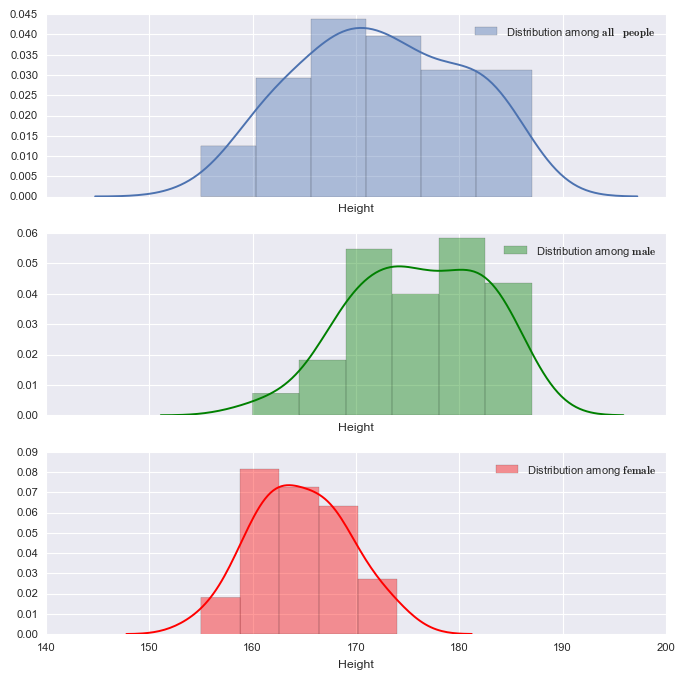

In [492]:
sns.set_context('paper')

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

sns.distplot(raw['Height'], ax=ax1, label=r'Distribution among $\mathbf{all \quad people}$')
ax1.legend(loc='best')
sns.distplot(raw_male['Height'], ax=ax2, color='g', label=r'Distribution among $\mathbf{male}$')
ax2.legend(loc='best')
sns.distplot(raw_female['Height'], ax=ax3, color='r', label=r'Distribution among $\mathbf{female}$')
ax3.legend(loc='best')

plt.show()

sns.set_context('poster')

Looking at the distributions of separated datasets, we have more confidence in the decision of seperation. Then again **let's do the normality hypothesis tests**:

In [498]:
print 'Test reulsts of male: '
norm_test(raw_male)

Test reulsts of male: 


SkewnessTest KurtosisTest OmnibusTest Chi-SquaredTest  \
Variable                                                                     
Height     Statistic    -0.905891     -1.28614     2.47479         9.69792   
           P value        0.36499      0.19839     0.29014        0.286871   
Weight     Statistic      2.35823     0.774982     6.16186         9.25161   
           P value        0.01836      0.43835     0.04592        0.321517   
ArmSpan    Statistic    -0.448459      1.41954     2.21621         4.42853   
           P value        0.65382      0.15574     0.33018         0.81654   
Leglength  Statistic    -0.945271     0.716981      1.4076         11.9682   
           P value        0.34452      0.47339      0.4947        0.152629   
FeetLength Statistic     -1.48213     0.229991     2.24959         17.0124   
           P value        0.13831       0.8181     0.32472       0.0299807   

                     ShapiroTest  
Variable                          
Height     Statistic     0.97152  
           P value      0.165648  
Weight     Statistic    0.950767  
           P value     0.0156812  
ArmSpan    Statistic     0.98185  
           P value      0.500221  
Leglength  Statistic    0.961613  
           P value     0.0530957  
FeetLength Statistic    0.953595  
           P value     0.0214434

In [499]:
print 'Test reulsts of female: '
norm_test(raw_female)

Test reulsts of female: 


SkewnessTest KurtosisTest OmnibusTest Chi-SquaredTest  \
Variable                                                                     
Height     Statistic     0.210931    -0.301882    0.135625         2.54751   
           P value        0.83294      0.76274     0.93444        0.769323   
Weight     Statistic     0.644927     0.378535     0.55922          1.6827   
           P value        0.51897      0.70503     0.75608        0.891072   
ArmSpan    Statistic     -1.27461      1.39078      3.5589          1.1728   
           P value        0.20245      0.16429     0.16873         0.94746   
Leglength  Statistic    -0.197791    -0.752731    0.605725         3.89058   
           P value        0.84321      0.45161      0.7387        0.565275   
FeetLength Statistic     -1.31978     0.330281     1.85091         6.39527   
           P value        0.18691      0.74119     0.39635        0.269634   

                     ShapiroTest  
Variable                          
Height     Statistic    0.980794  
           P value      0.857783  
Weight     Statistic    0.983895  
           P value      0.924182  
ArmSpan    Statistic    0.975309  
           P value      0.709531  
Leglength  Statistic    0.970784  
           P value      0.581134  
FeetLength Statistic    0.948623  
           P value       0.16856

At least for the `Height` variable, it is **very close to normal distribution** now.

#### Test whether the means of two normal distribution are the same

Two steps are needed:
1. Test the **ratio of variances** of the two distributions
2. Test the **difference between means** of the two distributions (to do this we need first to know the result of step.1)

Let's calculate the sample means and variances as a guide of hypothesis tests:

In [564]:
print raw_male.ix[:, 1].describe()
print raw_female.ix[:, 1].describe()

count     61.000000
mean     176.073770
std        6.362544
min      160.000000
25%      172.000000
50%      175.000000
75%      181.000000
max      187.000000
Name: Height, dtype: float64
count     29.000000
mean     164.620690
std        4.546693
min      155.000000
25%      162.000000
50%      165.000000
75%      168.000000
max      174.000000
Name: Height, dtype: float64


For the **hypothesis test of ratio of variances** (we use suffix 1 to denote male, 2 for female):

$$
H_0: \frac{\sigma_1^2}{\sigma_2^2} = 1, \qquad H_1: \frac{\sigma_1^2}{\sigma_2^2} > 1
$$

The statistic is:
$$
F = \frac{S_1^2}{S_2^2} \sim F(n_1 - 1, n_2 - 1)
$$

Reject region is:
$$
\{F \quad | \quad \frac{S_1^2}{S_2^2} > F_{\alpha}(n_1 - 1, n_2 - 1)\}
$$

Calculate this:

In [579]:
statistic_F = raw_male.ix[:, 'Height'].var() / raw_female.ix[:, 'Height'].var() 
print 'F = {0}, the corresponding P value = {1}'.format(statistic_F, 
                                                     1 - scst.f.cdf(statistic_F, dfn=len(raw_male)-1, dfd=len(raw_female) - 1))

F = 1.95826029888, the corresponding P value = 0.02681460578


This means we can reject the null hypothesis at a significance level $\alpha \approx 3\%$. That is, their variances are different. The variance of the `Height` of male is larger.

To test the **difference between means**, the hypothesis is:
$$
H_0: a_1 = a_2, \qquad H_1: a_1 > a_2
$$

we need to use this formula:
$$
\zeta_i = \xi_i - \sqrt{\frac{n_2}{n_1}} \eta_i + \frac{1}{n_2 n_1} \sum_{i=1}^{n_2} \eta_i - \bar{\eta}
$$

Reject region is
$$
\left\{ 
\left|
\frac{\bar{\xi} - \bar{\eta}}
{\bar{S_{\zeta}} / \sqrt{n_2 - 1}}
\right|
> t_{1-\alpha/2}(n_2 - 1)
\right\} 
$$
Note that in current context, **the number of female is less**. $\xi$ stands for female, while $\eta$ stands for male.

In [595]:
zeta = raw_female.ix[:, 'Height'].values - raw_male.ix[:len(raw_female), 'Height'].values 
print zeta

[-26.   -1.  -12.  -17.   -5.  -16.  -21.  -14.  -21.  -29.   -1.  -16.
 -22.    4.  -13.   -7.   -1.  -25.  -24.  -16.  -16.  -15.   -2.    0.
 -14.5 -16.  -19.  -20.   -2. ]


In [596]:
statistic_zeta = (raw_female.ix[:, 'Height'].mean(axis=0) 
                  - raw_male.ix[:, 'Height'].mean(axis=0)) / zeta.var() * np.sqrt(len(raw_female) - 1)
print 'T = {0}, the corresponding P value = {1}'.format(statistic_zeta, 
                                                        scst.t.cdf(statistic_zeta, df=len(raw_female) - 1))

T = -0.770351109719, the corresponding P value = 0.223771556575


Quite surprisingly, we **cannot reject the null hypothesis**, i.e. the means of two distributions are the same.

However, note that **if we exchange $H_0$ and $H_1$, the test result will be the opposite**, this is because the statistic is rather "mild". As a consequence, **it is up to our belief whether the means are the same**.

## PART 3: Regression Analysis

In the following regression, we **choose not to differentiate male and female as two linear models** for two reasons:
1. Our **dataset is rather small**. Spliting will result in smaller dataset, which is not capable to provide **enough trainning** to our models. (See `Appendix` part for the regression results for different genders, its performance is poor)
2. "Only 1 model for all genders" is more **simple and powerful**. It also enables us to use the variable `Gender` as a predictor.

### Regression Without Partitioning Sample is NOT SERIOUS

In most contexts, especially modern ones (such as computer vision, natural language processing, financial engineering, etc.), we **do regression in order to make predictions**. Therefore we must partition out sample datasets into *trainging* and *test* part (sometimes called *in-sample* and *out-sample* part). The *trainning* part is used to **validate our models** and **avoid overfitting**.

We use 75% as training, 25% as testing:

In [657]:
X, Y = raw.ix[:, [0, 2, 3, 4, 5]], raw.ix[:, 1]
X_train, X_test, Y_train, Y_test = skl.model_selection.train_test_split(X, Y, test_size=0.25, random_state = 369)

### Benchmark: A Horizonal Regression Line

Before doing any regression analysis, we need to build **a simple model as a benchmark of more advanced models**. Also it is worthwhile to check whehter models we build later can surpass the benchmark . Because sometimes our models are no better than a monkey. This is often encountered in classification tasks. But we will still check it.

Since we are just doing *simple linear regression*, we use **horizonal line centered at $\bar{Y}$ as a benchmark**.

Let's see its performance on training and testing set:

In [645]:
"Rsquare on training dataset: {0}; Rsquare on testing dataset: {1}.".format(
    skl.metrics.r2_score(Y_train.values, Y_train.mean() * np.ones_like(Y_train)),
    skl.metrics.r2_score(Y_test, Y_test.mean() * np.ones_like(Y_test))
    )

'Rsquare on training dataset: 0.0; Rsquare on testing dataset: 0.0.'

Of course, we can also derive this result just using the definition of *coefficent of determination*.

### Simple Regression Model

We would like to see performances of each predictor and whether they are siginificant as a single varibale:

In [656]:
central = lambda x: x - x.mean(axis=0)

In [659]:
for col, ser in X_train.iteritems():
    model = sm.OLS(Y_train, sm.add_constant(ser))
    results = model.fit()
    print(results.summary())
    print skl.metrics.r2_score(Y_test, results.predict(sm.add_constant(X_test.loc[:, col])))
    print '\n\n\n'

                            OLS Regression Results                            
Dep. Variable:                 Height   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     62.92
Date:                Sun, 18 Dec 2016   Prob (F-statistic):           3.85e-11
Time:                        11:12:25   Log-Likelihood:                -211.76
No. Observations:                  67   AIC:                             427.5
Df Residuals:                      65   BIC:                             431.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        164.8077      1.136    145.047      0.0

The *Rsquare* show each predictor is capable to predict `Height`. The *F and t test* show these predictors are significant and linear relationships truely exist.

Then let's combine all predictors together to create a multi-varibale model

### Multiple Regression Model

In [660]:
model = sm.OLS(Y_train, sm.add_constant(X_train))
res_ols = model.fit()
print(res_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                 Height   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     46.64
Date:                Sun, 18 Dec 2016   Prob (F-statistic):           1.39e-19
Time:                        11:21:52   Log-Likelihood:                -181.73
No. Observations:                  67   AIC:                             375.5
Df Residuals:                      61   BIC:                             388.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         87.0350      9.407      9.252      0.0

From the result of multiple regression, we have **several findings**:
1. The linear model is overall siginificant (tells from the F-test), but not all predictors are significant (such as `LegLength`, `FeetLength`)
2. The *Condition Number* is large, meaning the possible existence of *multicollinearity*.

We will first deal with multicollinearity using *centralization*, then eliminate non-significant predictors using *backward feature selection*.

### Dealing With Multicollinearity

Multicollinearity is problem that we can run into when we’re fitting a regression model, or other linear model. It refers to **predictors that are correlated with other predictors** in the model.

Quite often, multicollinearity arises because of the **interaction term**. Interaction terms and higher-order terms (e.g., squared and cubed predictors) and they are correlated with main effect terms because they **include the main effects terms**.

To reduce the effect produced by interaction and higher-order terms, we can **standardize** the continuous predictor variables. 

There are many ways of standardization. We’ll choose the *Subtract the mean* method, which is also known as *centering* the variables. This method removes the multicollinearity produced by interaction and higher-order terms as **effectively** as the other standardization methods, but it has the added benefit of **not changing the interpretation of the coefficients** (If you subtract the mean, each coefficient continues to estimate the change in the mean response per unit increase in X when all other predictors are held constant).

In [662]:
central = lambda x: x - x.mean(axis=0)
model_central = sm.OLS(Y_train, sm.add_constant(central(X_train)))
res_central = model_central.fit()
print(res_central.summary())

                            OLS Regression Results                            
Dep. Variable:                 Height   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     46.64
Date:                Sun, 18 Dec 2016   Prob (F-statistic):           1.39e-19
Time:                        11:41:29   Log-Likelihood:                -181.73
No. Observations:                  67   AIC:                             375.5
Df Residuals:                      61   BIC:                             388.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        171.8582      0.467    368.216      0.0

Perfect! Now the condition number reduces from $4140$ to only $39.4$. Meanwhile all test statistics and rsquare remain unchanged.

#### Regression diagnalstics & Plots #TODO

In [722]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [726]:
def conf_interval(result, x, y):
    res = result
    prstd, iv_l, iv_u = wls_prediction_std(res)

    fig, ax = plt.subplots(figsize=(8,6))

    ax.plot(x, y, 'o', label="data")
    #ax.plot(x, y_true, 'b-', label="True")
    ax.plot(x, res.fittedvalues, 'r--.', label="OLS")
    ax.plot(x, iv_u, 'r--')
    ax.plot(x, iv_l, 'r--')
    ax.legend(loc='best');

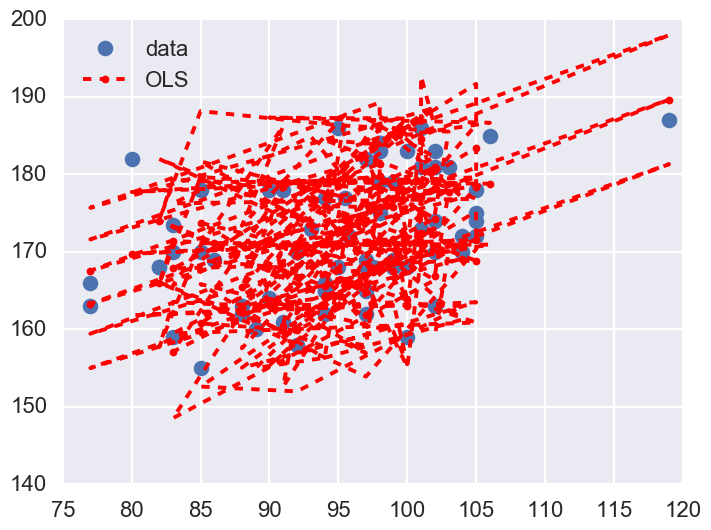

In [728]:
conf_interval(res_central, X_train.ix[:, 3], Y_train)

In [720]:
def plot_fit(res, xin, yin, xout=None, yout=None, n=0):
    if type(res) == sm.regression.linear_model.RegressionResultsWrapper:
        xin = sm.add_constant(xin)
        n += 1
    plt.figure(figsize=(20,8))
    plt.scatter(xin.ix[:, n],
                yin, label='Data', facecolors='none', s=120, edgecolors='k', linewidth='2')
    plt.hold('on')
    plt.scatter(xin.ix[:, n],
                res.predict(xin), label='Prediction', color='b', alpha=0.6, 
                #edgecolors='none', 
                s=120)
    plt.legend(loc='best')
    plt.title('variable: [{0}]'.format(xin.columns[n]))

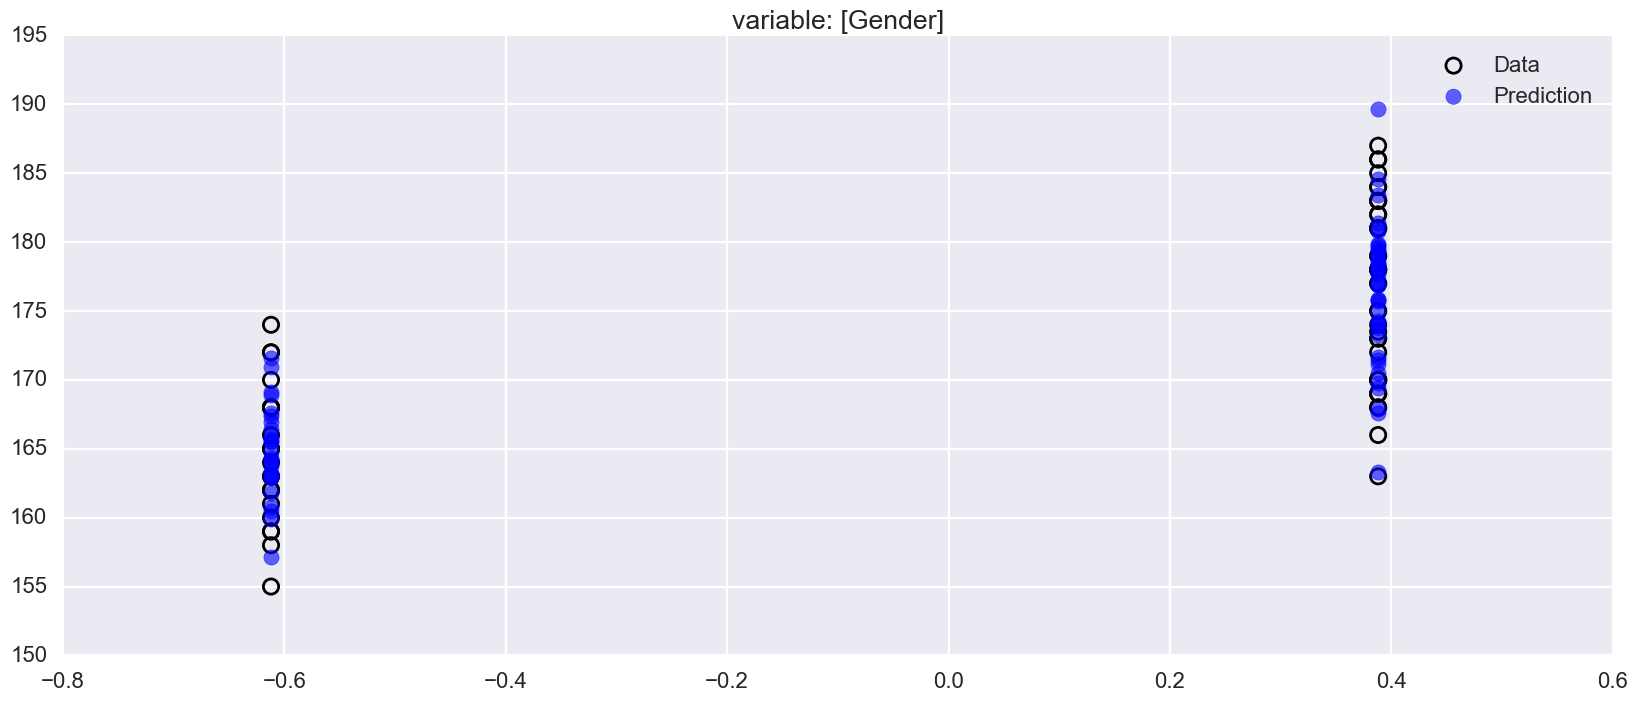

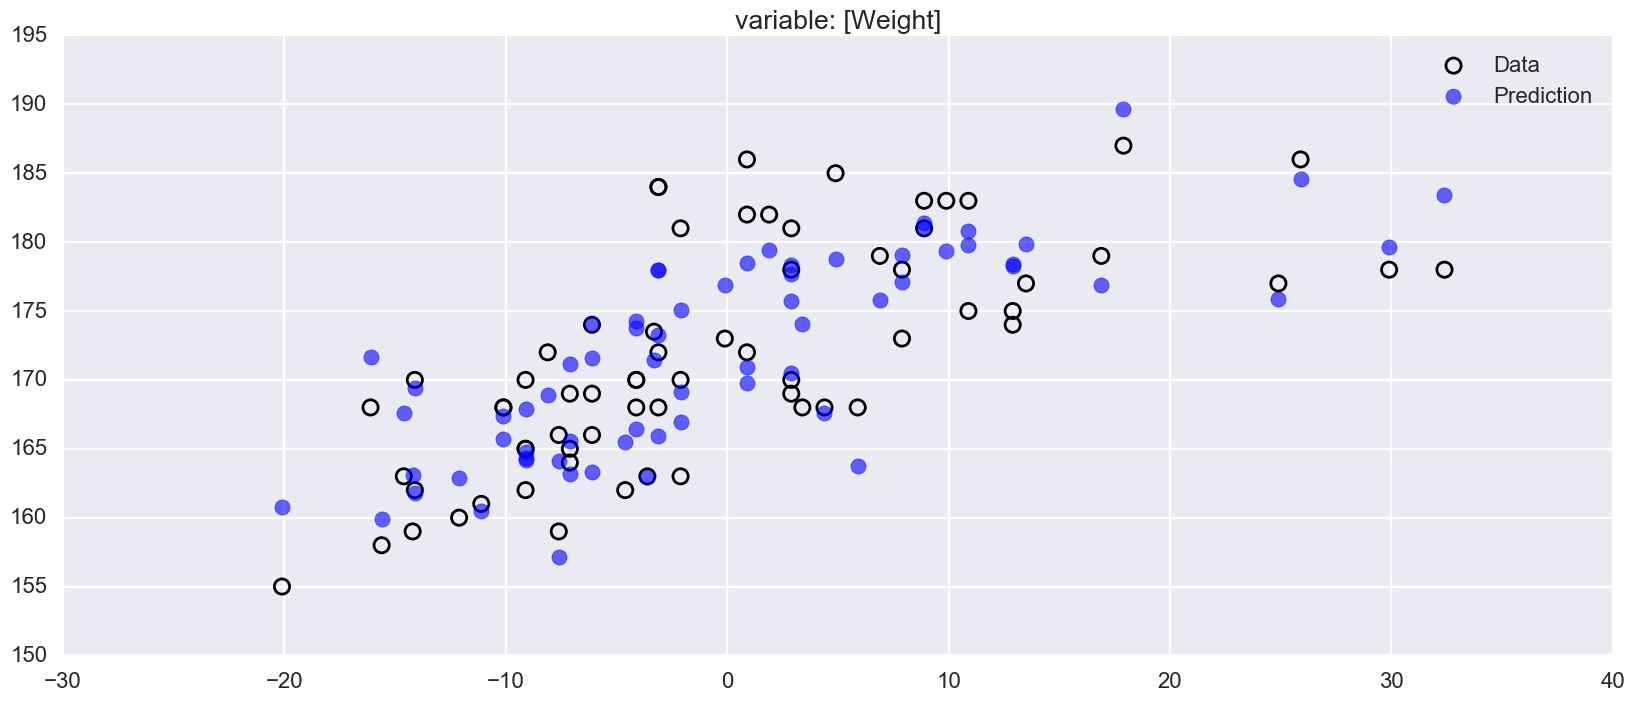

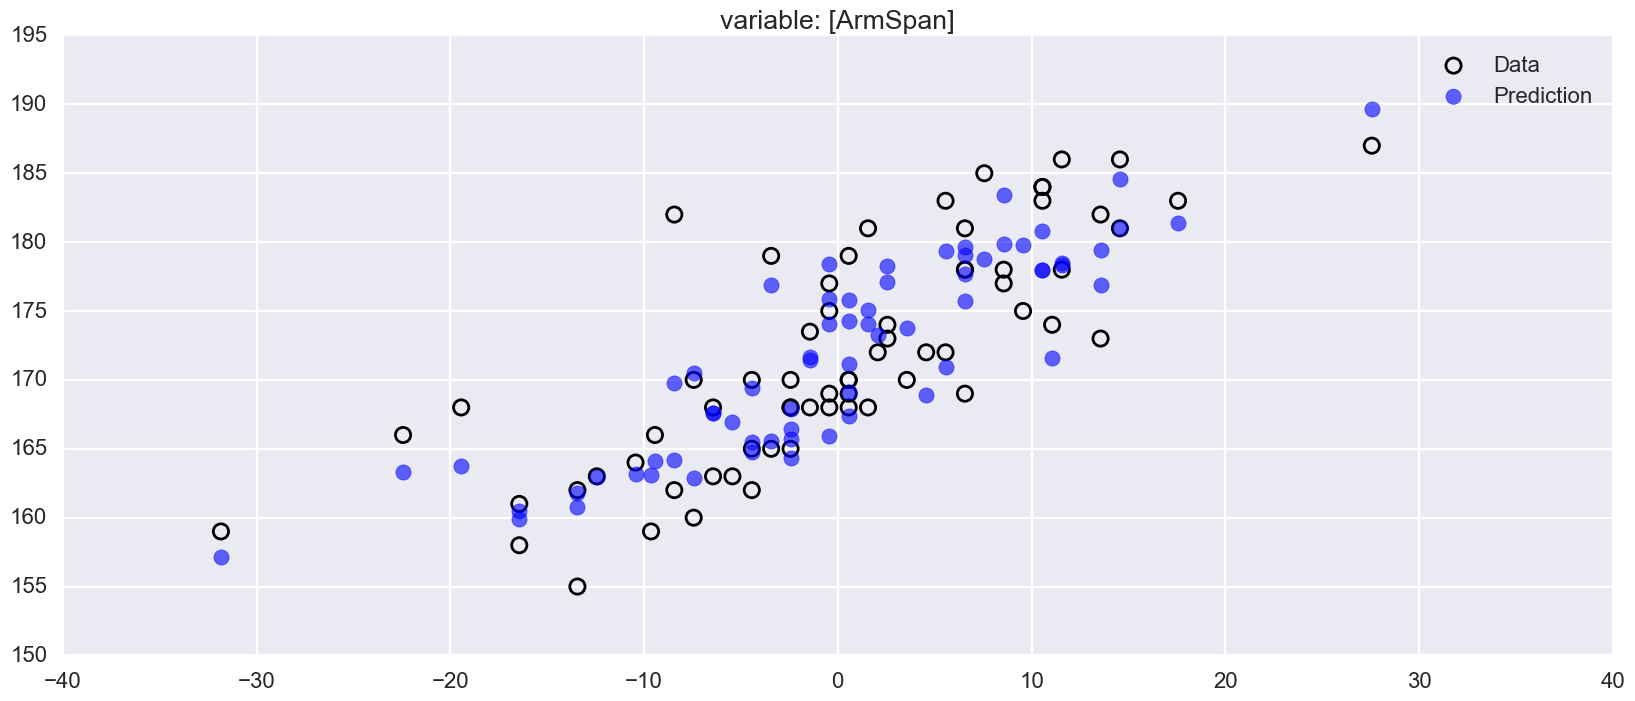

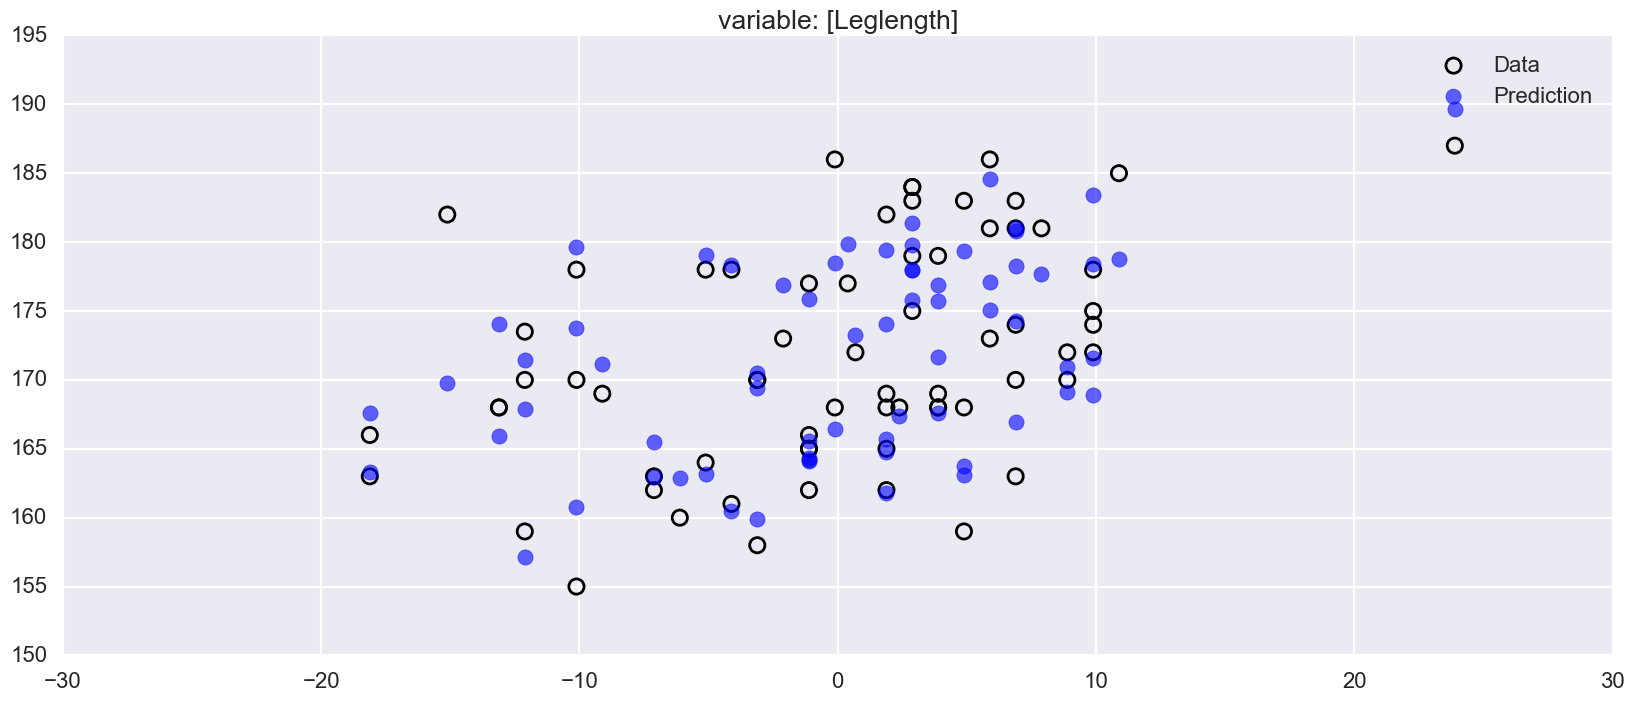

In [721]:
#print central(X_train).ix[:, [0, 1]]
for i in range(4):
    plot_fit(res_central, central(X_train), Y_train, n=i)
    plt.show()

In [619]:
rgsr_ols = sklm.LinearRegression()
res_ols = rgsr_ols.fit(X_train, Y_train)
print res_ols.score(X_train, Y_train)
print res_ols.coef_
print res_ols.intercept_

0.729298802734
[ 4.26863665  0.15721169  0.24596752  0.0532564   0.92862848]
89.4632849516


In [518]:
rgsr_ridge = sklm.Ridge(alpha=4000.1)
res_ridge = rgsr_ridge.fit(X_train, Y_train)
print res_ridge.score(X_train, Y_train)
print res_ridge.coef_

0.681614100561
[ 0.21208998  0.3031477   0.0656228   0.06210857]


0.77538964117417886

In [413]:
print raw.head(5)
res_ols.coef_

       Gender  Height  Weight  ArmSpan  Leglength  FeetLength
Index                                                        
1           1   185.0    65.0    188.0      102.0        25.1
2           1   173.0    62.0    182.0       93.0        23.5
3           1   175.0    80.3    183.0      107.0        26.5
4           1   182.0    74.3    189.0      114.0        26.0
5           1   173.0    55.7    185.0      107.0        26.0


array([ 0.58490229,  0.03333027])

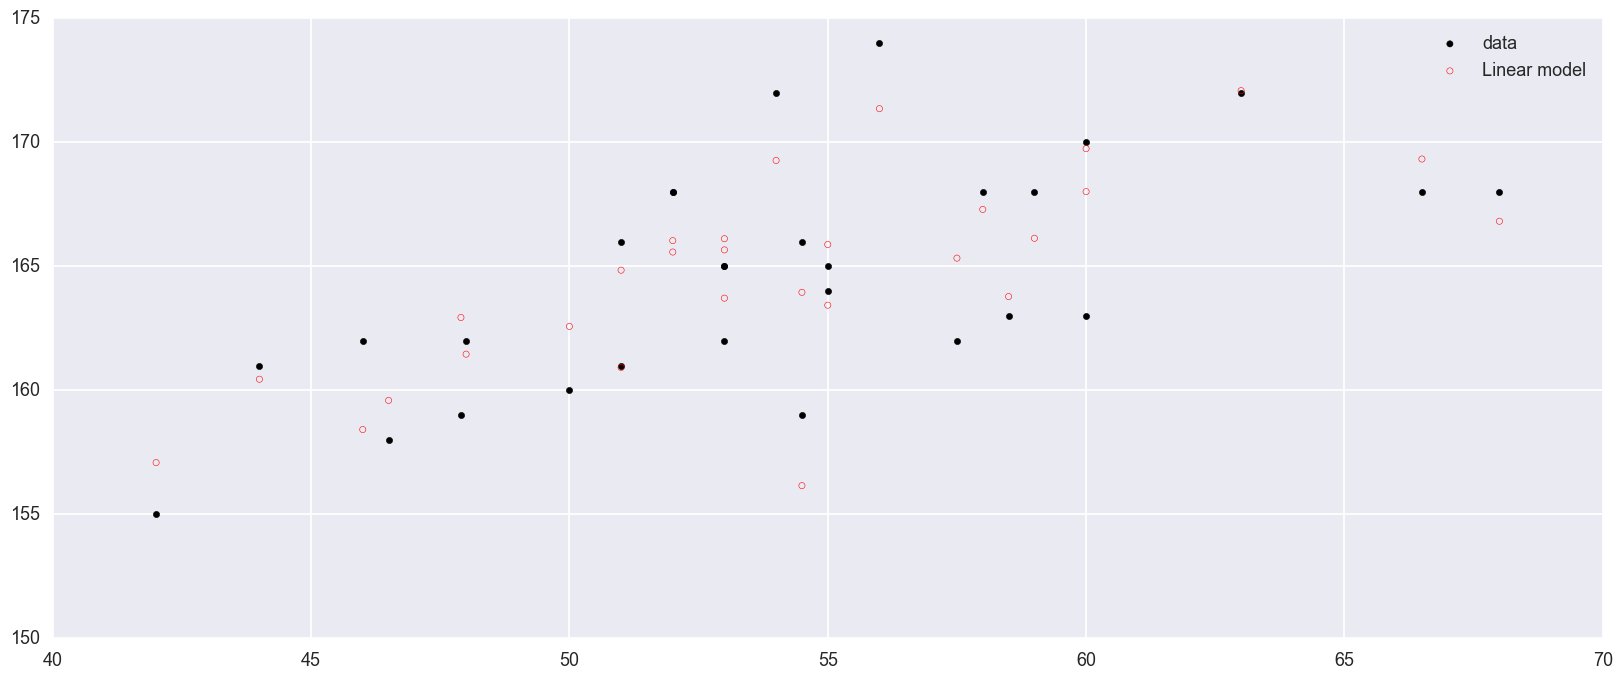

In [456]:
plot_fit(res_ols, X_train, Y_train, n=0)

### SVR

In [440]:
rgsr_svr = skl.svm.SVR(kernel='rbf', gamma='auto', C=100, epsilon=3)
res_svr = rgsr_svr.fit(X_train, Y_train)

In [458]:
for myc in np.arange(15, 16, 1):
    rgsr_svr = skl.svm.SVR(kernel='rbf', gamma='auto', C=myc, epsilon=3)
    res_svr = rgsr_svr.fit(X_train.ix[::2, :], Y_train.ix[::2])
    print len(res_svr.support_vectors_)
    print res_svr.score(X_train, Y_train)
    print res_svr.score(X_train.ix[1::2], Y_train.ix[1::2])


9
0.282678594143
0.60382931035


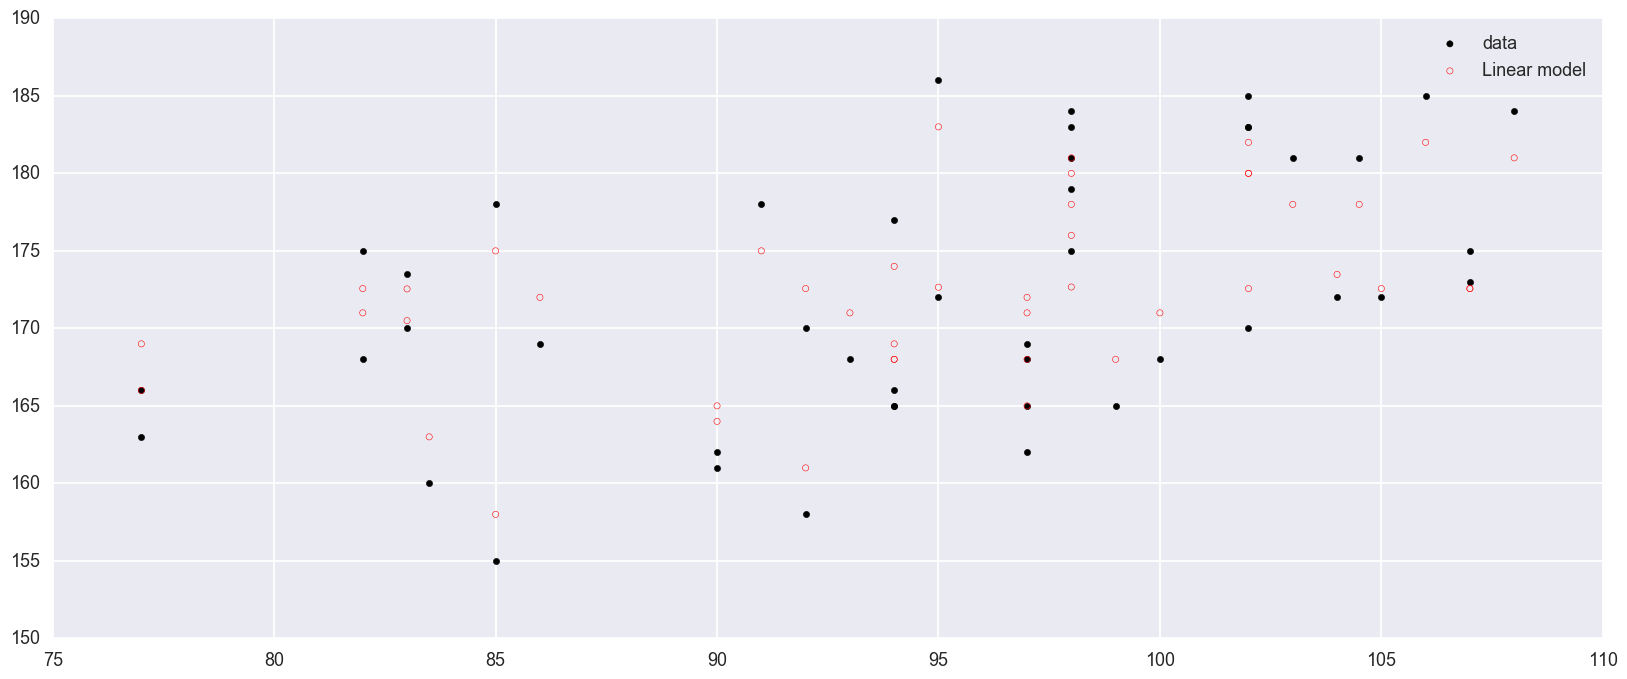

In [450]:
plot_fit(res_svr, X_train.ix[1::2], Y_train.ix[1::2], n=2)

### content
- every single variable regression
- multi variable regression
- multicolinearity in minitab, centralization to avoid high cond. number
- step by step feature selection
- compare to a horizonal line prediction
- unlinear models

- follow the tutorials of statsmodels

## Memo

- Singular matrix linear regression
- Step by step feature selection
- enconding under advanced unlinear models

## Reference

- D'Agostino, R., & Pearson, E. (1973). Tests for Departure from Normality. Empirical Results for the Distributions of b2 and √ b1. *Biometrika*, 60(3), 613-622. doi:10.2307/2335012
- Razali, N. M., & Wah, Y. B. (2011). Power comparisons of shapiro-wilk, kolmogorov-smirnov, lilliefors and anderson-darling tests. *Journal of statistical modeling and analytics*, 2(1), 21-33.
- Schilling, M., Watkins, A., & Watkins, W. (2002). Is Human Height Bimodal? *The American Statistician*, 56(3), 223-229. Retrieved from http://www.jstor.org/stable/3087302

## Appendix

### Regression results for male and female respectively

In [626]:
mask = X_train['Gender'] == 1
model_male = sm.OLS(Y_train.ix[mask], sm.add_constant(central(X_train.ix[mask, 1:])))
res_male = model_male.fit()
print(res_male.summary())

                            OLS Regression Results                            
Dep. Variable:                 Height   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     11.11
Date:                Sun, 18 Dec 2016   Prob (F-statistic):           5.67e-06
Time:                        09:47:01   Log-Likelihood:                -117.14
No. Observations:                  41   AIC:                             244.3
Df Residuals:                      36   BIC:                             252.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        176.3293      0.702    251.149      0.0

In [610]:
central = lambda x: x - x.mean(axis=0)
mask = X_train['Gender'] == 0
model_female = sm.OLS(Y_train.ix[mask], sm.add_constant(central(X_train.ix[mask, 1:])))
res_female = model_female.fit()
print(res_female.summary())

                            OLS Regression Results                            
Dep. Variable:                 Height   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     23.99
Date:                Sun, 18 Dec 2016   Prob (F-statistic):           2.27e-06
Time:                        09:41:18   Log-Likelihood:                -37.323
No. Observations:                  20   AIC:                             84.65
Df Residuals:                      15   BIC:                             89.62
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        163.9000      0.404    405.889      0.0

## Cells below should be excluded from the report

In [263]:
# norm_test_res = pd.DataFrame(index=['Skewness', 'Kurtosis', 'Omnibus', 'Chi-Squared', 'Shapiro'], 
#                              columns=['Statistic', 'P value', 'Variable'])
# norm_test_res.index.name = 'Test Name'
index=['Skewness', 'Kurtosis', 'Omnibus', 'Chi-Squared', 'Shapiro']
columns=['Statistic', 'P value']
df_list = []

for col, ser in raw.iteritems():
    if col == 'Gender':
        continue
    """
    print 
    print deco_delim('variable [{0}]'.format(col), 20, 60, '=')
    
    print 
    print deco_delim('The result of Skewness&Kurtosis test:', 10, 60, '-')
    print norm_test_sk(ser)
    
    bins, observed, expected = norm_test_chisq(ser)
    st1, pv1 = scst.chisquare(observed, expected)
    print 
    print deco_delim('The result of Chi-Squared test:', 10, 60, '-')
    print 'statistic: {0} \n'.format(st) +' '*2 + 'P value: {0}'.format(pv)
    
    print 
    print deco_delim('The result of Shapiro test:', 10, 60, '-')
    print scst.shapiro(ser)
    st2, pv2 = scst.shapiro(ser)
    """
    df = pd.DataFrame(index=index, columns=columns,)
    df.ix[0: 3, :2] = norm_test_sk(ser).values
    df.ix[3, :2] = st1, pv1
    df.ix[4, :2] = st2, pv2
    #df.loc[:, 'Variable'] = col
    df_list.append(df)


====================variable [Height]=======================

----------The result of Skewness&Kurtosis test:-------------
              Statistic  P value
Test Name                       
Skewtest      -0.083903  0.93313
Kurtosistest  -3.114583  0.00184
Omnitest       9.707668  0.00780

----------The result of Chi-Squared test:-------------------
statistic: 12.4827948782 
  P value: 0.187439036206

----------The result of Shapiro test:-----------------------
(0.9728114604949951, 0.055891621857881546)

====================variable [Weight]=======================

----------The result of Skewness&Kurtosis test:-------------
              Statistic  P value
Test Name                       
Skewtest       3.181374  0.00147
Kurtosistest   1.312555  0.18933
Omnitest      11.843942  0.00268

----------The result of Chi-Squared test:-------------------
statistic: 12.4827948782 
  P value: 0.187439036206

----------The result of Shapiro test:-----------------------
(0.9474046230316162, 0.0011

In [240]:
def deco_delim(s, nleft=10, ntotal=10, delim='-'):
    return delim * nleft + s + delim * (ntotal - len(s) - nleft)

In [3]:

def CommonStats(arr):
    arr = np.array(arr)
    

    sts_dic = {}
    sts_dic['mean'] = arr.mean()
    sts_dic['var'] = arr.var()
    sts_dic['std'] = np.sqrt(sts_dic['var'])
    sts_dic['var1'] = ((arr - sts_dic['mean'])**2).sum() / (len(arr) - 1)
    sts_dic['std1'] = np.sqrt(sts_dic['var1'])
    sts_dic['m2o'] = (arr**2).mean()
    sts_dic['ran'] = arr.max() - arr.min()

    sts_tb = pd.Series(sts_dic)
    sns.distplot(arr, kde=True, rug=True)
    plt.show()

    return sts_tb


-0.898752466917
0.188224371855


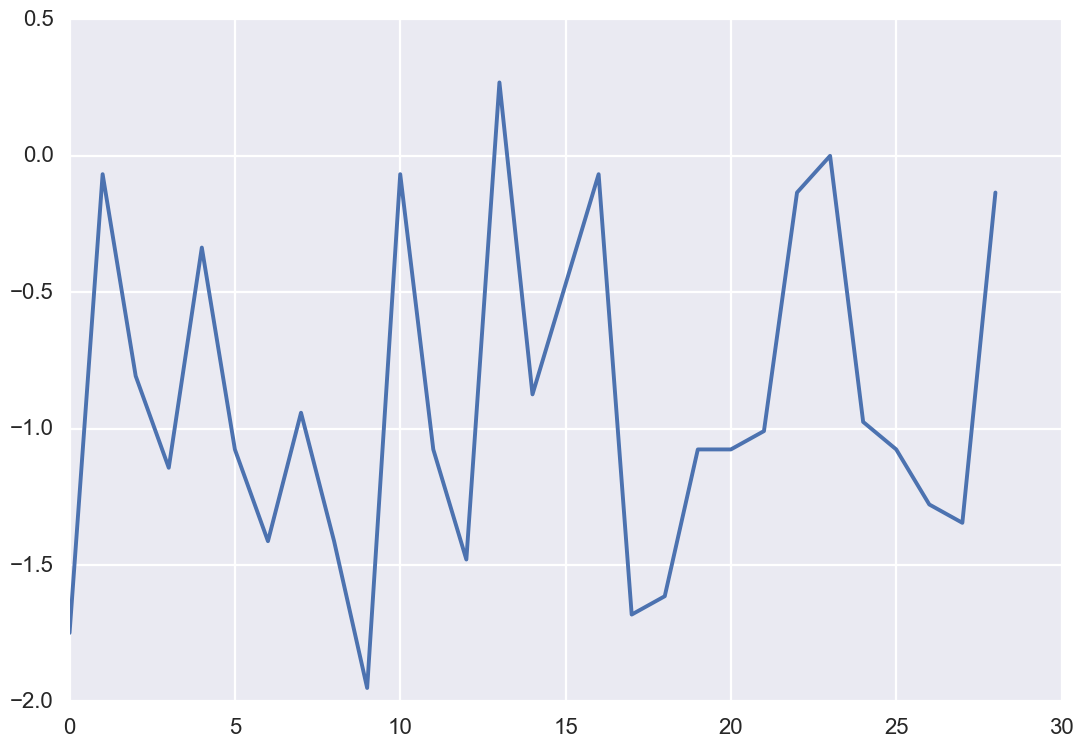

In [594]:
tmp = zeta.mean() / zeta.var() * np.sqrt(len(zeta) - 1) 
print tmp
print scst.t.cdf(tmp, df=len(zeta) - 1)
plt.plot(zeta / zeta.var() * np.sqrt(len(zeta) - 1))

In [608]:
tmp = X_train.ix[mask, :].head(5)
print tmp
print central(tmp)
sm.add_constant(central(X_train.ix[mask, :]))

       Gender  Weight  ArmSpan  Leglength  FeetLength
Index                                                
4           1    74.3    189.0      114.0        26.0
55          1    53.0    166.0       83.0        20.0
21          1    65.0    180.0       91.0        26.5
28          1    75.0    168.0      105.0        27.0
46          1    70.0    175.0       90.0        29.0
       Gender  Weight  ArmSpan  Leglength  FeetLength
Index                                                
4         0.0    6.84     13.4       17.4         0.3
55        0.0  -14.46     -9.6      -13.6        -5.7
21        0.0   -2.46      4.4       -5.6         0.8
28        0.0    7.54     -7.6        8.4         1.3
46        0.0    2.54     -0.6       -6.6         3.3


,Gender,Weight,ArmSpan,Leglength,FeetLength
Index,,,,,
4,0.0,7.848936,14.910638,17.780851,0.92766
55,0.0,-13.451064,-8.089362,-13.219149,-5.07234
21,0.0,-1.451064,5.910638,-5.219149,1.42766
28,0.0,8.548936,-6.089362,8.780851,1.92766
46,0.0,3.548936,0.910638,-6.219149,3.92766
13,0.0,6.548936,4.910638,5.780851,1.92766
29,0.0,-6.451064,-14.089362,-3.219149,-3.07234
47,0.0,-11.451064,-5.089362,-10.219149,-2.07234
31,0.0,8.548936,6.910638,8.280851,0.42766
